In [ ]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

## 載入CIFAR10資料

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transform),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transform),
    batch_size=batch_size)

Files already downloaded and verified


## 取出一部分資料來視覺化

In [3]:
def show_grid_img(img_tensor):
    img_tensor = img_tensor/2 +0.5
    i = torchvision.utils.make_grid(img_tensor).numpy()
    i = np.transpose(i,(1,2,0))
    plt.imshow(i)

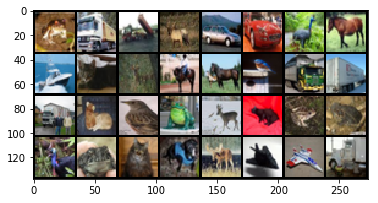

In [4]:
data,target = next(iter(train_loader))
show_grid_img(data)

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 每一個batch的資料維度

In [6]:
data.size()

torch.Size([32, 3, 32, 32])

In [7]:
target


 6
 9
 9
 4
 1
 1
 2
 7
 8
 3
 4
 7
 7
 2
 9
 9
 9
 3
 2
 6
 4
 3
 6
 6
 2
 6
 3
 5
 4
 0
 0
 9
[torch.LongTensor of size 32]

# Q1 定義神經網路模型(40/100)
## (1)請根據cifar10資料特性設計神經網路架構

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,inputs):
        x = F.relu(self.conv1(inputs))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        
        return logits

## (2)測試模型能否正常運作

In [9]:
net = Net()

In [10]:
predict = net(Variable(data))

In [11]:
predict.size()

torch.Size([32, 10])

## (3)測試能否計算loss

In [12]:
F.cross_entropy(predict,Variable(target))

Variable containing:
 2.2978
[torch.FloatTensor of size 1]

----------------------------------------------------------------------------------------------------------------------
# Q2 訓練模型並畫出 learning curve
## (1)調整 batch_size

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64 # you can change batch size

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=False,
                   transform=transform),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transform),
    batch_size=batch_size)

In [14]:
criterion = nn.CrossEntropyLoss()

## (2)選擇優化演算法

In [15]:
train_op = optim.Adam(net.parameters())

## (3)訓練神經網路

In [16]:
%%time
n_epochs = 12 #you can change here
train_loss_history = []

for epoch in range(n_epochs):
    batch_train_loss_ = []
    
    for _, (data, target) in enumerate(train_loader):
        
        data = Variable(data) 
        target = Variable(target)
        
        train_op.zero_grad()

        outputs = net(data)
        batch_train_loss = criterion(outputs, target)
        batch_train_loss.backward()
        train_op.step()
        
        batch_train_loss_.append(batch_train_loss.data[0])
    
    batch_train_loss = np.mean(batch_train_loss_)
    train_loss_history.append(batch_train_loss)
    print "epoch:%s , train_loss:%s" % (epoch , batch_train_loss)

epoch:0 , train_loss:1.66104921203
epoch:1 , train_loss:1.36295699692
epoch:2 , train_loss:1.24364315206
epoch:3 , train_loss:1.16132396162
epoch:4 , train_loss:1.09755662983
epoch:5 , train_loss:1.0433349431
epoch:6 , train_loss:0.997912840999
epoch:7 , train_loss:0.957746167546
epoch:8 , train_loss:0.92497120771
epoch:9 , train_loss:0.895287615793
epoch:10 , train_loss:0.868150235442
epoch:11 , train_loss:0.843908446905
CPU times: user 6min 13s, sys: 1min 28s, total: 7min 42s
Wall time: 7min 4s


## (4)畫出每個 epoch對 train_loss learning curve 

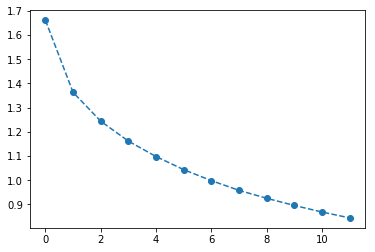

In [17]:
plt.plot(range(0,epoch+1) , train_loss_history,'o--')

----------------------------------------------------------------------------------------------------------------------
# Q3 於測試資料上的正確率

In [29]:
correct = list(0. for i in range(10))
total = list(0. for i in range(10))
for data in test_loader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        correct[label] += c[i]
        total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * correct[i] / total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 82 %
Accuracy of  bird : 36 %
Accuracy of   cat : 45 %
Accuracy of  deer : 49 %
Accuracy of   dog : 49 %
Accuracy of  frog : 64 %
Accuracy of horse : 73 %
Accuracy of  ship : 62 %
Accuracy of truck : 65 %


In [30]:
correct = 0
n_testsets = 10000.0
loss_ = []

for _, (data, target) in enumerate(test_loader):
    outputs = net(Variable(data))
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == target).sum()

In [31]:
correct

6237

In [32]:
correct / n_testsets

0.6237